In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
from sklearn.neighbors import KernelDensity

In [2]:
df = pd.read_csv('airway.csv')

In [3]:
x = np.log(np.array(df.baseMean))
y = (np.array(df.lfcSE))

p = np.array(df.pvalue)
n_samples = len(x)
print n_samples

33469


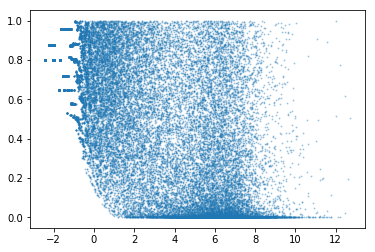

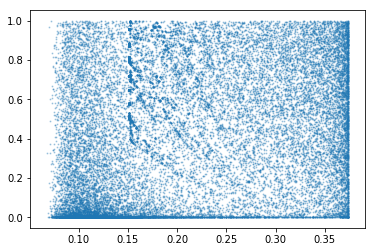

In [4]:
plt.figure()
plt.scatter(x,p, 1, alpha = 0.3)

plt.figure()
plt.scatter(y,p, 1, alpha = 0.3)

In [5]:
import torch
import torch.nn as nn
from torch.autograd import Variable
import torch.optim as optim

In [6]:
network = nn.Sequential(
        nn.Linear(2,10),
        nn.LeakyReLU(0.1),
        nn.Linear(10,10),
        nn.LeakyReLU(0.1),
        nn.Linear(10,10),
        nn.LeakyReLU(0.1),
        nn.Linear(10,10),
        nn.LeakyReLU(0.1),
        nn.Linear(10,1),
        nn.Sigmoid()
)

soft_compare = nn.Sigmoid()

In [7]:
optimizer = optim.Adagrad(network.parameters(), lr = 0.005)

In [8]:
loss_hist = []
batch_size = 2000
for iteration in range(20000):
    
    choice = np.random.choice(n_samples, batch_size)
    
    x_input = Variable(torch.from_numpy(x[choice].astype(np.float32).reshape(batch_size,1)))
    y_input = Variable(torch.from_numpy(y[choice].astype(np.float32).reshape(batch_size,1)))
    p_input = Variable(torch.from_numpy(p[choice].astype(np.float32).reshape(batch_size,1)))
    
    x2 = torch.cat([x_input, y_input], 1)
    
    optimizer.zero_grad()
    output = network.forward(x2) * 0.2
    s = torch.sum(soft_compare((output - p_input) * 1e3)) / batch_size
    s2 = torch.sum(soft_compare((p_input - (1-output)) * 1e3)) / batch_size
    
    gain = s  - 2 * soft_compare((s2 - s*0.05) * 50) 
    
    loss = -gain
    loss.backward()
    optimizer.step()
    loss_hist.append(loss.data[0])

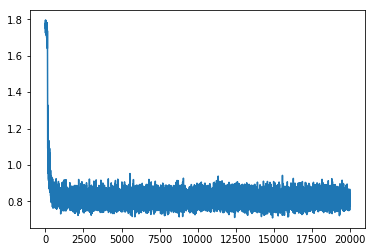

In [9]:
plt.plot(loss_hist)

In [10]:
s

Variable containing:
 0.1061
[torch.FloatTensor of size 1]

In [11]:
s2/s

Variable containing:
1.00000e-02 *
  1.3524
[torch.FloatTensor of size 1]

In [12]:
x_input = Variable(torch.from_numpy(x.astype(np.float32).reshape(n_samples ,1)))
y_input = Variable(torch.from_numpy(y.astype(np.float32).reshape(n_samples ,1)))


p_input = Variable(torch.from_numpy(p.astype(np.float32).reshape(n_samples ,1)))

x2 = torch.cat([x_input, y_input], 1)

output = network.forward(x2) * 0.2
pred = (p_input < output).data.numpy()
pred = pred[:,0].astype(np.float32)

In [13]:
np.sum(pred)

3833.0

In [14]:
def BH(x, alpha = 0.05):
    x_s = sorted(x)
    n = len(x_s)
    ic = 0
    for i in range(n):
        if x_s[i] < i*alpha/float(n):
            ic = i
    return ic, x_s[ic]

In [15]:
BH(p)

(3471, 0.0051812577689410002)

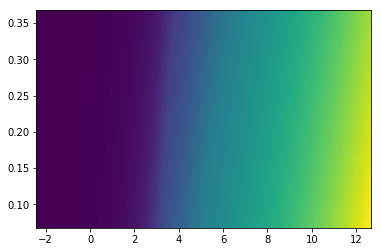

In [16]:
x_probe = np.arange(min(x), max(x), 0.05)
y_probe = np.arange(min(y), max(y), 0.01)

X, Y = np.meshgrid(x_probe, y_probe)

x_input = np.concatenate([[X.flatten()],[Y.flatten()]]).T

th = network(Variable(torch.from_numpy(x_input.astype(np.float32))))

th = th.data.numpy().reshape(X.shape)

plt.pcolor(X, Y, th)